tt: [ 0.          0.20408163  0.40816327  0.6122449   0.81632653  1.02040816
  1.2244898   1.42857143  1.63265306  1.83673469  2.04081633  2.24489796
  2.44897959  2.65306122  2.85714286  3.06122449  3.26530612  3.46938776
  3.67346939  3.87755102  4.08163265  4.28571429  4.48979592  4.69387755
  4.89795918  5.10204082  5.30612245  5.51020408  5.71428571  5.91836735
  6.12244898  6.32653061  6.53061224  6.73469388  6.93877551  7.14285714
  7.34693878  7.55102041  7.75510204  7.95918367  8.16326531  8.36734694
  8.57142857  8.7755102   8.97959184  9.18367347  9.3877551   9.59183673
  9.79591837 10.        ]
time_index (50,) float32
u (50, 20, 40) float32
v (50, 20, 40) float32
w (50, 20, 40) float32
y_coordinates (40,) float32
z_coordinates (20,) float32


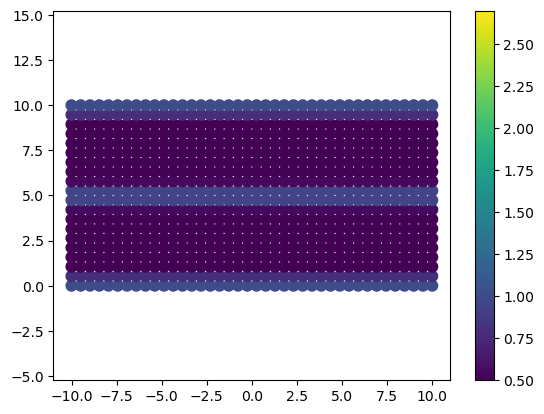

In [7]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import h5py

np.random.seed(0)

y_min = -10.0
y_max = 10.0
ny = 40

z_min = 0.0
z_max = 10.0
nz = 20

yy = np.linspace(y_min, y_max, ny)
zz = np.linspace(z_min, z_max, nz)

t_final = 10.0
t_steps = 50

tt = np.linspace(0, t_final, t_steps)

print("tt:", tt)

yy_mesh, zz_mesh = np.meshgrid(yy, zz)

u = 7.0 + 0.5*np.cos(2*2.0*np.pi/(y_max-y_min)*np.add.outer(tt, np.sqrt(yy_mesh**2+zz_mesh**2))).reshape(t_steps, nz, -1)
v = np.cos(2*2.0*np.pi/(y_max-y_min)*np.add.outer(tt, yy_mesh)).reshape(t_steps, nz, -1)
w = np.cos(2*2.0*np.pi/(z_max-z_min)*np.add.outer(tt, zz_mesh)).reshape(t_steps, nz, -1)


# v = 1.0 * (np.random.rand(t_steps, nz, ny) - 0.5)
# w = 1.0 * (np.random.rand(t_steps, nz, ny) - 0.5)

# def smooth_data(data_in):
    
#     nt, nz, ny = np.shape(data_in)
    
#     num_smoothing_iters = 2
        
#     data_out = np.zeros((nt, nz, ny))
#     data_out[:, :, :] = data_in[:, :, :]
    
#     for z in range(num_smoothing_iters):
#         for k in range(nt):
#             if k == 0:
#                 k_r = [0, 1+1]
#             elif k == nt-1:
#                 k_r = [nt-2, nt-1+1]
#             else:
#                 k_r = [k-1, k+1+1]
                
#             for j in range(nz):
#                 if j == 0:
#                     j_r = [0, 1+1]
#                 elif j == nz-1:
#                     j_r = [nz-2, nz-1+1]
#                 else:
#                     j_r = [j-1, j+1+1]
                
#                 for i in range(ny):
#                     if i == 0:
#                         i_r = [0, 1+1]
#                     elif i == ny-1:
#                         i_r = [ny-2, ny-1+1]
#                     else:
#                         i_r = [i-1, i+1+1]

#                     neigh_sum = np.sum(data_in[k_r[0]:k_r[1],
#                                               j_r[0]:j_r[1],
#                                               i_r[0]:i_r[1]])
#                     data_out[k, j, i] = 1/27.0 * neigh_sum
                    
#         data_in[:, :, :] = data_out[:, :, :]
        
#     return data_out

# u = smooth_data(u)
# v = smooth_data(v)
# w = smooth_data(w)

# plt.scatter(yy_mesh, zz_mesh, c=u[0, :, :], s=60)
# plt.show()

with h5py.File("turb_data.h5", "w") as fp:
    fp.create_dataset("time_index", shape=(t_steps,))
    fp["time_index"][:] = tt
    
    fp.create_dataset("y_coordinates", shape=(ny,))
    fp["y_coordinates"][:] = yy
        
    fp.create_dataset("z_coordinates", shape=(nz,))
    fp["z_coordinates"][:] = zz
        
    fp.create_dataset("u", shape=(t_steps, nz, ny))
    fp["u"][:] = u[:]
    
    fp.create_dataset("v", shape=(t_steps, nz, ny))
    fp["v"][:] = v[:]
    
    fp.create_dataset("w", shape=(t_steps, nz, ny))
    fp["w"][:] = w[:]
        
    
with h5py.File("turb_data.h5", "r") as fp:
    for key, val in fp.items():
        print(key, val.shape, val.dtype)
        
    yy_mesh, zz_mesh = np.meshgrid(fp["y_coordinates"][:], fp["z_coordinates"][:])
    cbar = plt.scatter(yy_mesh, zz_mesh, c=fp["w"][0, :, :], s=60, vmin=0.5, vmax=2.7)
    plt.colorbar(cbar)
    plt.axis("equal")

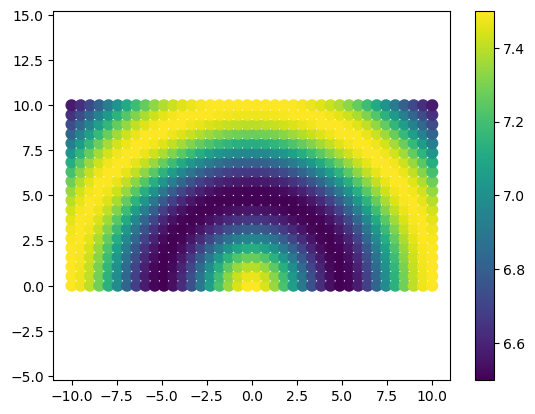

In [8]:
with h5py.File("turb_data.h5", "r") as fp:        
    yy_mesh, zz_mesh = np.meshgrid(fp["y_coordinates"][:], fp["z_coordinates"][:])
    cbar = plt.scatter(yy_mesh, zz_mesh, c=fp["u"][0, :, :], s=60) #, vmin=0.5, vmax=2.7)
    plt.colorbar(cbar)
    plt.axis("equal")

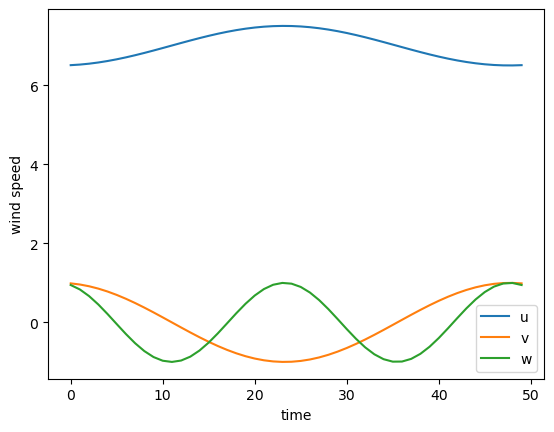

In [9]:
with h5py.File("turb_data.h5", "r") as fp:
    plt.plot(fp["u"][:, 10, 20], label='u')
    plt.plot(fp["v"][:, 10, 20], label='v')
    plt.plot(fp["w"][:, 10, 20], label='w')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('wind speed')


In [10]:
%reset -f

import dolfinx
import gmsh
import numpy as np
import ufl
import h5py
import time

import scipy.interpolate as interp

from petsc4py import PETSc

from mpi4py import MPI

comm = MPI.COMM_WORLD

ndim = 3

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)

domain = gmsh.model.occ.addBox(0, -10.0, 0.0, 10.0, 20.0, 10.0)

gmsh.model.occ.removeAllDuplicates()
gmsh.model.occ.synchronize()

all_points = gmsh.model.getEntities(0)
gmsh.model.mesh.setSize(all_points, 0.5)

gmsh.model.mesh.generate(ndim)

vol_tag_list = gmsh.model.occ.getEntities(ndim)

for k, vol_tag in enumerate(vol_tag_list):
    vol_id = vol_tag[1]
    gmsh.model.add_physical_group(ndim, [vol_id], k+1)

surf_tag_list = gmsh.model.occ.getEntities(ndim-1)

for k, surf_tag in enumerate(surf_tag_list):
    surf_id = surf_tag[1]
    gmsh.model.add_physical_group(ndim-1, [surf_id], k+1)
        
mesh, cell_tags, facet_tags = dolfinx.io.gmshio.model_to_mesh(gmsh.model, comm, 0, gdim=ndim)
gmsh.finalize()


ve_2 = ufl.VectorElement("Lagrange", mesh.ufl_cell(), degree=2)
V = dolfinx.fem.FunctionSpace(mesh, ve_2)

inflow_vel_fn = dolfinx.fem.Function(V, name="inflow_vel_fn")
u = dolfinx.fem.Function(V, name="velocity")



class TurbInflowVelocity:
    def __init__(self, current_time, h5_filename, inflow_dofs):
        self.current_time = current_time
        
        with h5py.File(h5_filename, "r") as fp:
            self.time_index = fp["time_index"][:]
            self.y_coordinates = fp["y_coordinates"][:]
            self.z_coordinates = fp["z_coordinates"][:]
            self.u = fp["u"][:]
            self.v = fp["v"][:]
            self.w = fp["w"][:]
        
        # Create the known axes for our interpolators (t0, z0, y0)
        x0 = (self.time_index, self.z_coordinates, self.y_coordinates)
        
        self.interp_u = interp.RegularGridInterpolator(x0, self.u, bounds_error=False, fill_value=None)
        self.interp_v = interp.RegularGridInterpolator(x0, self.v, bounds_error=False, fill_value=None)
        self.interp_w = interp.RegularGridInterpolator(x0, self.w, bounds_error=False, fill_value=None)
        
        self.inflow_dofs = inflow_dofs
        
    def __call__(self, x):
        # Preallocated velocity vector that we will fill
        inflow_velocity = np.zeros((3, x.shape[1]), dtype=PETSc.ScalarType)
        
        # We will interpolate at these (z, y) points,
        # but need to know the current time, too
        
        xi_0_mask = x[0] < 1e-5
        ti = self.current_time * np.ones(np.sum(xi_0_mask))
        
#         print("inflow_mask", np.sum(xi_0_mask))
#         print("dofs", len(self.inflow_dofs))

        xi = np.vstack((ti, x[2][xi_0_mask], x[1][xi_0_mask])).T
        
        u_vel = self.interp_u(xi)
        v_vel = self.interp_v(xi)
        w_vel = self.interp_w(xi)
        
        inflow_velocity[0, xi_0_mask] = u_vel
        inflow_velocity[1, xi_0_mask] = v_vel
        inflow_velocity[2, xi_0_mask] = w_vel
        
        return inflow_velocity


def _inflow_entities(x):
    eps = 1.0e-5

    x_edge = x[0] < eps

    return x_edge

inflow_entities = dolfinx.mesh.locate_entities_boundary(mesh, ndim-1, _inflow_entities)
inflow_dofs = dolfinx.fem.locate_dofs_topological(V, ndim-1, inflow_entities)

# turb_inflow_velocity = TurbInflowVelocity(0.0, "turb_data.h5", inflow_dofs)
turb_inflow_velocity = TurbInflowVelocity(0.0, "pct_turb_data.h5", inflow_dofs)
# turb_inflow_velocity = TurbInflowVelocity(0.0, "pct_turb_sonic1_10min.h5", inflow_dofs)
inflow_vel_fn.interpolate(turb_inflow_velocity)


bcs = []
bcs.append(dolfinx.fem.dirichletbc(inflow_vel_fn, inflow_dofs))

dt = 0.1
t_final = 10.0
t_steps = int(t_final/dt)

tic = time.time()

for k in range(t_steps):
    if k == 0:
        with dolfinx.io.XDMFFile(comm, "applied_bcs.xdmf", "w") as xdmf_file:
            xdmf_file.write_mesh(mesh)
    
    current_time = k*dt
    turb_inflow_velocity.current_time = current_time
    inflow_vel_fn.interpolate(turb_inflow_velocity)
#     print(f"Interpolating at t = {current_time:.3f}")
    
    dolfinx.fem.petsc.set_bc(u.vector, bcs)
    
    with dolfinx.io.XDMFFile(comm, "applied_bcs.xdmf", "a") as xdmf_file:
        xdmf_file.write_function(u, current_time)

toc = time.time()

print(f"Elapsed Time = {toc-tic:.3f}s")

Elapsed Time = 8.381s
